In [1]:
import matplotlib.pyplot as plt

import mygrad as mg
import numpy as np

%matplotlib notebook

# Training a Universal Function Approximator

The purpose of a function approximator is to be able to approximate some function $f(x)$ on some finite domain $x \in [x_{\mathrm{min}}, x_{\mathrm{max}}]$, whose form may be extremely complicated (or unknown!), with a simpler **model function**, $F_{\mathrm{model}}(x)$.
The universal function approximation (UFA) theorem provides us with the general form for this model function:

\begin{equation}
F(\{v_i\}_{i=1}^{N}, \{w_i\}_{i=1}^{N}, \{b_i\}_{i=1}^{N}; x) = \sum_{i=1}^{N} v_{i}\varphi(x \cdot w_{i} + b_{i})
\end{equation}


where $(\{v_i\}_{i=1}^{N}, \{w_i\}_{i=1}^{N}, \{b_i\}_{i=1}^{N})$ are our **model's parameters**.
The **size** of our model, $N$, determines the number of parameters in our model. We are responsible for choosing a value for $N$.

$\varphi(\cdot)$ is a non-linear, continuous, and bounded function.
That is, it has the "on/off" pattern of the so-called activation functions that we analyzed in the previous notebook.
A common example of $\varphi(\cdot)$ is the "sigmoid" function:

\begin{equation}
\sigma(wx + b) = \frac{1}{1 + e^{-(wx + b)}}
\end{equation}

The **universal function approximation theorem** says that, given a large enough value for $N$, we can *always* find values for $(\{v_i\}_{i=1}^{N}, \{w_i\}_{i=1}^{N}, \{b_i\}_{i=1}^{N})$ in order to make $F(x)$ an arbitrarily good approximation of $f(x)$.

That is, for any positive value $\varepsilon$ we can ensure that $F_{\mathrm{model}}(x)$ and $f_{\mathrm{true}}(x)$ never have a discrepancy larger than $\varepsilon$ within some finite domain for $x$.

\begin{equation}
| F_{\mathrm{model}}( x ) - f_{\mathrm{true}} ( x ) | < \varepsilon \;,\; x \in [x_{\mathrm{min}}, x_{\mathrm{max}}]
\end{equation}

Put another way: You can ask me to pick some (positive) value for $\varepsilon$. The universal function approximation theorem says that, no matter what value of $\varepsilon$ I pick, you can *always* find a model size ($N$) and find values for $((v_i)_{i=1}^{N}, (w_i)_{i=1}^{N}, (b_i)_{i=1}^{N})$ such that $| F_{\mathrm{model}}( x ) - f_{\mathrm{true}} ( x ) | < \varepsilon $, as long as we stick to the agreed upon finite domain for $x$.
In general, the smaller the value of $\varepsilon$ that you request, the larger $N$ will need to be to make $F_{\mathrm{model}}$ a closer approximation of $f_{\mathrm{true}}$.

In later work we will see that the UFA theorem is even more general than what we covered here; it extends to vector-valued functions that operate on vector spaces as well:

\begin{equation}
\vec{F}(\{\vec{v}_i\}_{i=1}^{N}, \{\vec{w}_i\}_{i=1}^{N}, \{b_i\}_{i=1}^{N}; \vec{x}) = \sum_{i=1}^{N} \vec{v}_{i}\varphi(\vec{x} \cdot \vec{w}_{i} + b_{i})
\end{equation}

this will be useful when we are dealing with non-scalar input data (e.g. $\vec{x}$ stores the pixels of an image), and when our function needs to return multiple values (e.g. $\vec{F(\vec{x}}$ returns confidence scores that an image depicts any one of ten classes of objects). 

(here is a more rigorous statement of the universal function approximation theorem: https://en.wikipedia.org/wiki/Universal_approximation_theorem)


## Our problem
Here, we will find values for the parameters $N,v_{i},b_{i},w_{i}$  (where $i=1,\cdots ,N$) such that $F(x)$ approximates 

\begin{equation}
f(x) = \cos(x)\\
x \in [-2\pi, 2\pi]
\end{equation}


We will use the aforementioned sigmoid function, $\sigma(x)$, as our activation function $\varphi(\cdot)$.

Our model size, $N$, is a **hyper parameter**, which we must find through trial and error, or some other means. I.e. $N$ is not something we can determine directly via gradient descent.

### Plotting our "activation function"

Here we will import the `sigmoid` from `mygrad.nnet.activations`. Plot this function on the domain $[-10, 10]$.

Note that `sigmoid` is designed to be a vectorized function just like NumPy's functions. I.e. you can feed it an array of values, and it will return an array of corresponding outputs:

```python
>>> x = np.array([-1, 0, 1])
>>> sigmoid(x)  # sigmoid is vectorized
Tensor([0.26894142, 0.5       , 0.73105858])
```

Let's plot the `sigmoid` activation function on the domain `[-10, 10]`

In [24]:
# run this cell to import the sigmoid activation function

from mygrad.nnet.activations import sigmoid

<IPython.core.display.Javascript object>


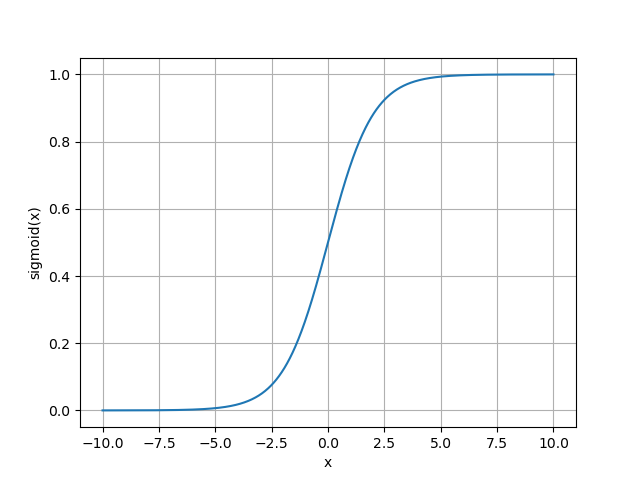

In [25]:
# plotting sigmoid(x)

fig, ax = plt.subplots()

x = np.linspace(-10, 10, 1000)  # <COGSTUB> use np.linspace to create 1,000 evenly-spaced points between [-10, 10]$\varepsilon$

y = sigmoid(x)  # <COGSTUB> evaluate the sigmoid function for all `x` values. 

ax.plot(x, y)

ax.grid()
ax.set_xlabel("x")
ax.set_ylabel("sigmoid(x)");

### Write a gradient-descent function

**Simply copy and paste the `gradient_step` function that you wrote/used in the Gradient Descent notebook and the Linear Regression notebook**.

In [26]:
def gradient_step(tensors, learning_rate):
    """
    Performs gradient-step in-place on each of the provides tensors 
    according to the standard formulation of gradient descent.

    Parameters
    ----------
    tensors : Union[Tensor, Iterable[Tensors]]
        A single tensor, or an iterable of an arbitrary number of tensors.

        If a `tensor.grad` is `None`for a specific tensor, the update on
        that tensor is skipped.

    learning_rate : float
        The "learning rate" factor for each descent step. A positive number.

    Notes
    -----
    The gradient-steps performed by this function occur in-place on each tensor,
    thus this function does not return anything
    """
    # paste your solution from a previous notebook here
    # <COGINST>
    if isinstance(tensors, mg.Tensor):
        # Only one tensor was provided. Pack
        # it into a list so it can be accessed via
        # iteration
        tensors = [tensors]

    for t in tensors:
        if t.grad is not None:
            t.data -= learning_rate * t.grad
    # </COGINST>

## Defining Our Model

### Working with "Batches" of Data

There are important advantages to updating our model using gradient descent based on *batches* of data, instead of based on individual predictions. It is both computationally inefficient to train our model by passing it one datum, $x$, at a time, plus the gradient of our loss function will be a crude estimate of the true gradient of the loss function if it is based only on one sample of data at a time. 

Thus we will want to pass in a **batch** of $M$ pieces of input data, $\{x_{j}\}_{j=0}^{M-1}$, and evaluate our model for each of these values independently.  That is, we will pass on a batch of $M$ pieces of data and produce $M$ corresponding predictions from our model.

We will pass in a "batch" of $M$ input values, $X_{\mathrm{batch}}$, as a shape-$(M, 1)$ vector to get $M$ corresponding predictions:


\begin{align}
F\big(X_{\mathrm{batch}}=\begin{bmatrix}
       x_{1} \\
       x_{2} \\
       \vdots \\
       x_{m}
     \end{bmatrix}\big) \rightarrow 
\begin{bmatrix}
       y^{\mathrm{pred}}_{1} \\
       y^{\mathrm{pred}}_{2} \\
       \vdots \\
       y^{\mathrm{pred}}_{m}
     \end{bmatrix}
\end{align}



Each prediction is made only on its corresponding piece of input data. Thus, prediction $y^{\mathrm(pred)}_j = F(\{v_i\}, \{w_i\}, \{b_i\}; x_j )$ depends only on:

- our model's parameters: $(v_i)_{i=1}^{N}, (w_i)_{i=1}^{N}, (b_i)_{i=1}^{N}$ 
- datum $x_j$

it is **not** impacted by any of the other pieces of data in the batch. This is very important to keep in mind!

We will make our $M$ predictions for the batch using vectorization and not for-loops. $X_{\mathrm{batch}}$ will be a shape-$(M, 1)$ numpy-array. It will soon become clear why we use the shape $(M, 1)$ instead of the more intuitive shape $(M,)$. 

Similarly, we can store our model's parameters in tensors of shrewdly-selected shapes to enable efficient vectorized computations of $F(X_{\mathrm{batch}})$:
- $(w_i)_{i=1}^{N}$ will be stored in a shape-(1, N) tensor
- $(b_i)_{i=1}^{N}$ will be stored in a shape-(N,) tensor
- $(v_i)_{i=1}^{N}$ will be stored in a shape-(N, 1) tensor

These shapes will also make it trivial for us to extend our code to working with vector-valued inputs/outputs instead of scalars in the future.

Let's see why these shapes pay off for us. Conveniently, we can calculate

\begin{equation}
x_j \cdot w_{i}
\end{equation}

for all combinations of $j=1,\cdots ,M$ and $i=1,\cdots , N$ via simple matrix multiplication between the shape-$(M, 1)$ `x` and the shape-$(1, N)$ `w`, producing a shape-$(M, N)$ output matrix storing those $M \times N$ combinations of products. 

And thus the following expression:

\begin{equation}
\varphi(x_{j} \cdot w_{i} + b_{i})
\end{equation}

can be performed for all combinations of $j$ and $i$ via the following line of code:

```python
sigmoid(mg.matmul(x, w) + b) # matmul[(M,1) w/ (1, N)] + (N,) --> (M, N)
```

where each $b_{i}$ is added to the ith column of the shape-(M, N) tensor via [broadcasted addition](https://numpy.org/doc/stable/user/basics.broadcasting.html).

Multiplying each such term by $v_{i}$ and summing over $i$ is just another matrix multiplication:

```python
model_out = mg.matmul(sig_out, v)  # matmul[(M, N) w/ (N, 1)] --> (M, 1)
```

Thus, in full, our model's prediction

\begin{equation}
F(\{v_i\}, \{w_i\}, \{b_i\}; x_j ) = \sum_{i=1}^{N} v_{i}\varphi(x_{j} \cdot w_{i} + b_{i})
\end{equation}

can be performed over the entire batch via:

```python
sig_out = sigmoid(mg.matmul(x, w) + b)  # matmul[(M,1) w/ (1, N)] + (N,) --> (M, N)
model_out = mg.matmul(sig_out, v)       # matmul[(M, N) w/ (N, 1)] --> (M, 1)
```

Thus `model_out` is a shape-$(M, 1)$ tensor that holds the prediction of our model, corresponding with each datum in our shape-(M, 1) batch.

The code that was just laid out here will help you fill out the upcoming `Model.__call__` method, such that it accepts a batch of shape-$(M, 1)$, and produces a shape-$(M, 1)$ tensor of corresponding predictions. 

In [27]:
# We will draw our model's initial parameter values from a 
# normal distribution (a.k.a Gaussian distribution or "bell curve")
# centered at 0 and with a standard deviation of 1
from mygrad.nnet.initializers import normal

In [28]:
class Model:
    
    def initialize_params(self, num_neurons: int):
        """
        Randomly initializes and sets values for  `self.w`,
        `self.b`, and `self.v`.
        
        Uses `mygrad.nnet.initializers.normal to randomly draw tensor
        values for w, b, and v from a normal distribution with
        0-mean and std-dev of 1.
        
        self.w : shape-(1, N)
        self.b : shape-(N,)
        self.v : shape-(N, 1)
        
        where `N` is the number of "neurons" in the model.
        """
        # Use the `normal` distribution to draw all of your v, w, and b values.
        #
        # E.g. `normal(num_neuron)` will return a shape-(N,) tensor of 
        # randomly-drawn values (where N is the number of neurons)
        #
        # `normal(1, num_neurons)` will return a shape-(1, N) tensor of
        # randomly-drawn values.
        #
        # assign `self.w`, `self.b`, and `self.v` each a tensor value drawn from
        # the appropriate distribution
        self.w = normal(1, num_neurons)  # <COGSTUB> draw the appropriately-shaped tensor from `normal` for w
        self.b = normal(num_neurons)  # <COGSTUB> draw the appropriately-shaped tensor from `normal` for b
        self.v = normal(num_neurons, 1)  # <COGSTUB> draw the appropriately-shaped tensor from `normal` for v
        
        # note that this method does not return anything -- it updates `self.w`, `self.b`, `self.v` in-place.
        
    def __init__(self, num_neurons: int):
        """
        Parameters
        ----------
        num_neurons : int
            The number of 'neurons', N, to be included in the model.
        """
        self.N = num_neurons  # <COGSTUB>  set self.N equal to `num_neurons`
        
        # Use `self.initialize_params()` to draw random values for
        # `self.w`, `self.b`, and `self.v` 
        self.initialize_params(num_neurons) # <COGLINE>
    
    def __call__(self, x):
        """
        Performs a so-called 'forward pass' through the model
        on the specified data. I.e. uses the model to
        make a prediction based on `x`.
        
        Parameters
        ----------
        x : array_like, shape-(M, 1)
            An array of M observations.
        
        Returns
        -------
        prediction : mygrad.Tensor, shape-(M, 1)
            A corresponding tensor of M predictions based on
            the form of the universal approximation theorem.
        """
        # Refer to the code that was described in the section above for guidance
        
        # <COGINST>
        sig_out = sigmoid(x @ self.w + self.b)  # matmul[(M,1) w/ (1, N)] + (N,) --> (M, N)
        out = sig_out @ self.v  # matmul[(M, N) w/ (N, 1)] --> (M, 1)
        return out
        # </COGINST>
    
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model"""
        # Return a tuple containing all of the model's trainable parameters
        # <COGINST>
        return (self.w, self.b, self.v)
        # </COGINST>
    
    def load_parameters(self, w, b, v):
        # Don't change this
        self.w = w
        self.b = b
        self.v = v

### Writing a loss function

We will use the following loss function

\begin{equation}
\mathscr{L}_{1} = \frac{1}{M}\sum_{j=1}^{M} | y_{j}^{\mathrm{pred}} - y_{j}^{\mathrm{true}} |
\end{equation}

This is often referred to as "L-1" ("ell one") loss.

Write the function `l1_loss`, which accepts the shape-$(M,1)$ batch of **predictions** from our model along with the shape-$(M, 1)$ **true** values (which we are hoping to approximate) and returns the average loss, $L$.

In [29]:
def l1_loss(pred, true):
    """
    Computes Mean[|pred - true|]
    
    Parameters
    ----------
    pred : mygrad.Tensor, shape=(M,)
        The values predicted by our model.
        
    true : mygrad.Tensor, shape=(M,)
        The values that our model *should* have predicted.
    
    Returns
    -------
    mygrad.Tensor, shape=()
        The l1-loss averaged over the size-M batch of predictions. This should
        be a 0D tensor.
    """
    # this is just like the mean squared-error loss, but instead of
    # squaring each difference you take the absolute value using 
    # the function `np.abs`
    
    diff = pred - true  # <COGSTUB> shape-(M, )
    abs_diff = np.abs(diff)  # <COGSTUB> shape-(M, )
    mean_abs_diff = np.mean(abs_diff)  # <COGSTUB> shape-()
    return mean_abs_diff 

Test your implementation of `l1_loss`. 

Create three pairs of `pred` / `true` tensors.
For each pair, compute by hand what $\frac{1}{M}\sum_{j=1}^{M} | y_{j}^{\mathrm{pred}} - y_{j}^{\mathrm{true}} |$ should be.
Then check that `l1_loss` returns the expected results. 

In [30]:
# <COGINST>
pred = mg.tensor([1.0, -1.0])
true = mg.tensor([0.0, 0.0])

print("loss should be (|1.0 - 0.0| + |-1.0 - 0.0|) / 2 = 1:", l1_loss(pred, true))


pred = mg.tensor([0.0, -1.0])
true = mg.tensor([0.0, 0.0])

print("loss should be (|0.0 - 0.0| + |-1.0 - 0.0|) / 2 = 1 / 2:", l1_loss(pred, true))

pred = mg.tensor([0.0, -10.0])
true = mg.tensor([10.0, 0.0])

print("loss should be (|0.0 - 10.0| + |-10.0 - 0.0|) / 2 = 10:", l1_loss(pred, true))
# </COGINST>

loss should be (|1.0 - 0.0| + |-1.0 - 0.0|) / 2 = 1: Tensor(1.)
loss should be (|0.0 - 0.0| + |-1.0 - 0.0|) / 2 = 1 / 2: Tensor(0.5)
loss should be (|0.0 - 10.0| + |-10.0 - 0.0|) / 2 = 10: Tensor(10.)


## Preparing the training data

You will create a numpy-array or *constant-Tensor* that samples the domain $[-2\pi, 2\pi]$ using 1,000 evenly-spaced points. Call this `train_data`. This should have the shape of (1000, 1). (You will do this lower down in the notebook).


### Training Our Approximating Function! 

We will need to make take randomized "batches" of our training data, and use them to train our model. Each time we process all of the batches in our training data, we have completed an "epoch" of training.

Below, we will use batches of size-25. Thus we will need to process $1000/25 = 40$ batches to complete an epoch of training.

Here, we will set up our training data, initialize our model's parameters, set our batch size, and define the function that we are attempting to approximate. We will also create a plot that updates during training

<IPython.core.display.Javascript object>


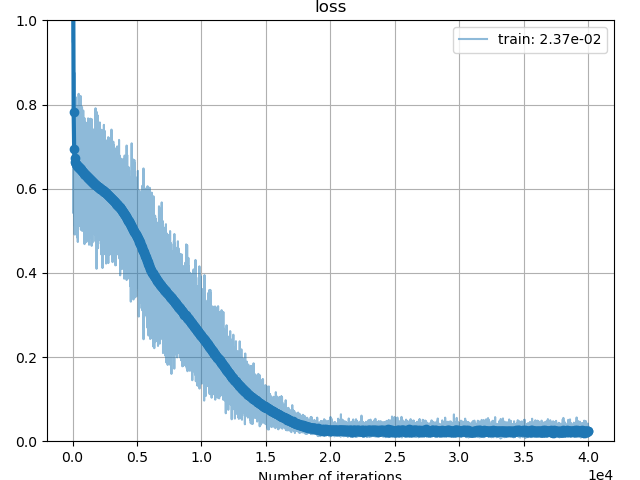

In [31]:
# Running this code will recreate your model, re-initializing all of its parameters
# Thus you must re-run this cell if you want to train your model from scratch again.

# Create the noggin figure (don't change this)
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss"])
ax.set_ylim(0, 1)


# Creating the shape-(1000, 1) training data...
#
# Here, we use np.linspace to create 1,000 evenly-spaced values between [-2pi, 2pi]
#
# Then, we use reshape this array from shape-(1000,) to shape-(1000, 1)
train_data = np.linspace(-2*np.pi, 2*np.pi, 1000).reshape(1000, 1)


model = Model(num_neurons=10)  # <COGSTUB> Initialize your model; start off with N=10 "neurons"

# Set the batch-size (referred to as M in our equations)
# This is the number of predictions that we will make in each training step
batch_size = 25 # <COGSTUB>  # start with the value 25

# Define the function `true_f`, which should just accept `x` and return `np.cos(x)`
# (or any other function that you want to approximate later on)
def true_f(x): 
    return np.cos(x)  # <COGLINE>


# We will store our model's weights in this list every 10 epochs 
# so that we can assess what our model's predictions look like mid-training.
# Don't change this
params = [] 

In [32]:
# After you complete the code in this cell, running it will train your model. 
# You can run it consecutively with different learning rates to continue training your model
# at different learning rates.

# When you run this cell, the plot above it will update in real-time. Check it out!

# `lr` is our learning rate for gradient descent
# Try a using value of 0.01 to start.
#
# If your loss function plateaus, you can reduce this by 10x and
# resume training (i.e. just re-run this cell) to further reduce the loss.
lr = 0.01  # <COGSTUB>

# An "epoch" means that the training data has been processed in full.
# Thus two epochs of training means that the model has processed / been updated
# by each datum in the dataset twice. 
#
# We will train for 1000 epochs; you can change this if you'd like
for epoch_cnt in range(1000):  
    ###### Drawing random indices to shuffle our data ########### 
    # For each new epoch we need to create randomly-drawn batches of data...

    # Create a numpy array of indices [0, 1, ..., T-1] where
    # T is the size – the number of pieces of data – of the training data
    idxs = np.arange(len(train_data))  # <COGSTUB>

    # Use np.random.shuffle to shuffle these indices.
    # Note that this functions will sort  the indices *in-place* - it does
    # not return anything
    
    np.random.shuffle(idxs)  # <COGLINE>

    # Let's keep track of our model's progress. Every 10 epochs we'll
    # record our model's weights so that we can visualize what its
    # predictions look like as it was training.
    # (Do not change this code)
    if epoch_cnt % 10 == 0:
        params.append([w.data.copy() for w in [model.w, model.b, model.v]])

    for batch_cnt in range(0, len(train_data) // batch_size):
        
        ########### Preparing our batch ##################
        # Take a size-`batch_size` (i.e. M) slice from the randomized indices 
        # that are stored in `idxs`. 
        # Each iteration of this for-loop should create a subsequent, non-overlapping slice
        # from `idxs` so that each datum will be included in a batch for a given epoch.
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]  # <COGSTUB>
        
        # `batch_indices` is now a shape-(M,) array of randomly shuffled indices.
        # We will use these to pick M pieces of data from our dataset to form a random 
        # "batch" of data.
        batch = train_data[batch_indices]  # <COGSTUB> this is a shape-(M, 1) tensor

        ########### Assessing our predictions ##############
        # Pass the shape-(M, 1) batch data to your model to produce a corresponding
        # shape-(M, 1) tensor of predictions 
        #
        predictions = model(batch)  # <COGSTUB>  A shape-(M, 1) tensor of model predictions

        # Use `true_f` to compute the true (a.k.a desired) values for this batch of data
        truth = true_f(batch)  # <COGSTUB>

        # Compute the loss associated with our predictions, compared to the true values
        loss = l1_loss(predictions, truth)  # <COGSTUB> 

        # Use mygrad's automatic differentiation capabilities to calculate the derivatives needed for 
        # updating our model's parameters: dL/dw, dL/db, and dL/db
        loss.backward() # <COGLINE>

        # Use your gradient-step function, passing all of your model's
        # parameters (w, b, v), and the learning rate. This will update your
        # model's parameters to minimize the loss
        #
        # Remember that your gradient-step function updates the parameter-values in-place.
        # It doesn't return anything
        gradient_step(model.parameters, lr)  # <COGLINE>

        # This will record the current loss, and will plot it
        plotter.set_train_batch({"loss": loss.item()}, batch_size=batch_size)  # (Don't change this)
    plotter.set_train_epoch()  # (Don't change this)

# this will ensure you plotted the most recent data
plotter.plot()

We should now expect to see that $F_{\mathrm{model}}(x) \approx \cos ( x )$ for $x \in [-2\pi, 2\pi]$.

To evaluate the quality of your model (i.e. your approximating function $F_{\mathrm{model}}(x)$), plot $f_{\mathrm{true}}(x)$ (the desired function) and $F_{\mathrm{model}}(x)$ on the sample plot. Use `train_data` as your `x` values. 

<IPython.core.display.Javascript object>


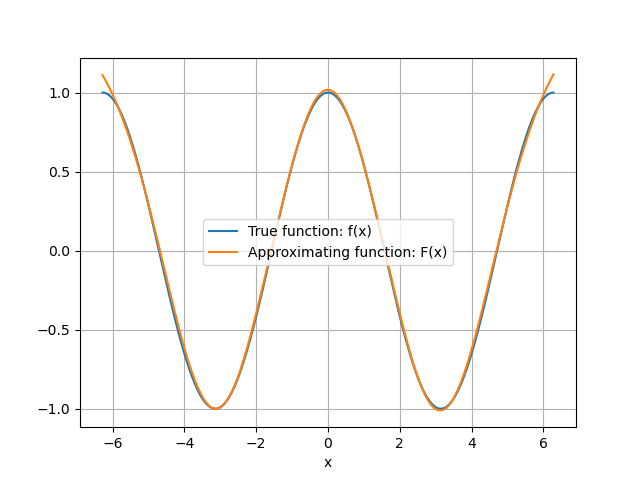

In [33]:
fig, ax = plt.subplots()

# <COGINST>
y_true = true_f(train_data)  # Compute the true values – true_f(x) – for all `x` in `train_data`
y_pred = model(train_data)  # Compute the predicted values – model(x) – for all `x` in `train_data`

ax.plot(train_data, y_true, label="True function: f(x)")
ax.plot(train_data, y_pred, label="Approximating function: F(x)")
ax.grid()
ax.set_xlabel("x")
ax.legend();
# </COGINST>

Let's see what our model looked like *as it was training/learning*. Run the following cell to see the true function (plotted in blue) and our approximating function (plotted in orange)

<IPython.core.display.Javascript object>


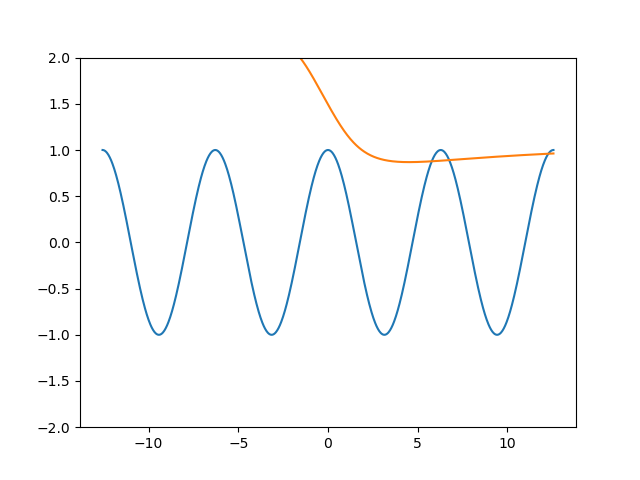

In [34]:
# Run this cell
# Don't change anything in this cell

from matplotlib.animation import FuncAnimation

x = np.linspace(-4 * np.pi, 4 * np.pi, 1000)



fig, ax = plt.subplots()
ax.plot(x, np.cos(x))
ax.set_ylim(-2, 2)
_model = Model(model.N)
_model.load_parameters(*params[0])
(im,) = ax.plot(x.squeeze(), _model(x[:, np.newaxis]).squeeze())


def update(frame):
    # ax.figure.canvas.draw()
    _model.load_parameters(*params[frame])
    im.set_data(x.squeeze(), _model(x[:, np.newaxis]).squeeze())
    return (im,)


ani = FuncAnimation(
    fig,
    update,
    frames=range(0, len(params)),
    interval=20,
    blit=True,
    repeat=True,
    repeat_delay=1000,
)

Let's visualize the form learned by each of our "neurons", scaled by . That is, we will plot

\begin{equation}
\varphi(x w_{i} + b_{i})
\end{equation}

for each $i=1, ..., N$ on $x \in [-2\pi, 2\pi]$. Note that $v_i$ is *not* included here.


<IPython.core.display.Javascript object>


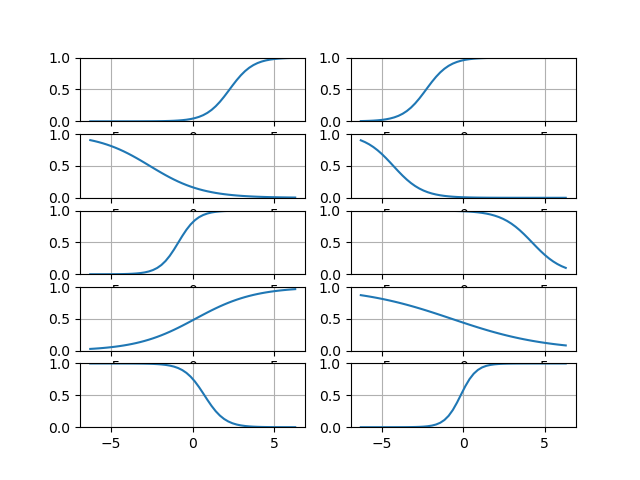

In [35]:
fig, axes = plt.subplots(ncols=2, nrows=model.N // 2)

x = np.linspace(-2 * np.pi, 2 * np.pi)  # <COGSTUB> create a shape-(50,) array evenly spaces on [-2pi, 2pi]

# `axes`, `model.w.data`, and `model.b.data` are all 2D numpy arrays, and each
# store (N,) elements
#
# Use the .ravel() method on each of these to transform them into flat arrays/tensors
# of shape-(N,)

# For each i in [0, 1, ..., N-1] plot sigmoid(x * w_i + b_i) in the ith `axes` object


flat_axes = axes.ravel()  # use .ravel() to make shape-(N,)
flat_w = model.w.ravel()  # use .ravel() to make shape-(N,)
flat_b = model.b.ravel()  # use .ravel() to make shape-(N,)

for i in range(model.N):
    ax = flat_axes[i]  # get axis-i
    w = flat_w[i]   # get w-i
    b = flat_b[i]  # get b-i
    
    # x is a shape-(50,) array of values evenly-spaced between [-2pi, 2pi]
    # w is a single number
    # b is a single number
    
    sig_out = sigmoid(x * w + b)  # compute the output of a single neuron
    ax.plot(x, sig_out)
    ax.set_ylim(0, 1)

for ax in axes.ravel():
    ax.grid("True")
    ax.set_ylim(0, 1)

Finally, let's include the scaling factors, $\{v_i\}_{i=1}^{N}$, each of which multiplies a respective neuron. That is, plot

\begin{equation}
v_{i}\varphi(x w_{i} + b_{i})
\end{equation}

for each $i$ on $x \in [-2\pi, 2\pi]$. 

**What will the result look like if you plot the sum of all of these curves? (Hint: look back to the form of the universal function approximation theorem**.


Your response here:

><COGNOTE>
ANSWER:
The sum of all of the scaled sigmoids is simply the full output of our model, which we know has been trained to approximate $\cos{x}$. Thus the sum of these curves should resemble $\cos{x}$ on $x \in [-2\pi, 2\pi]$.
</COGNOTE>

<IPython.core.display.Javascript object>


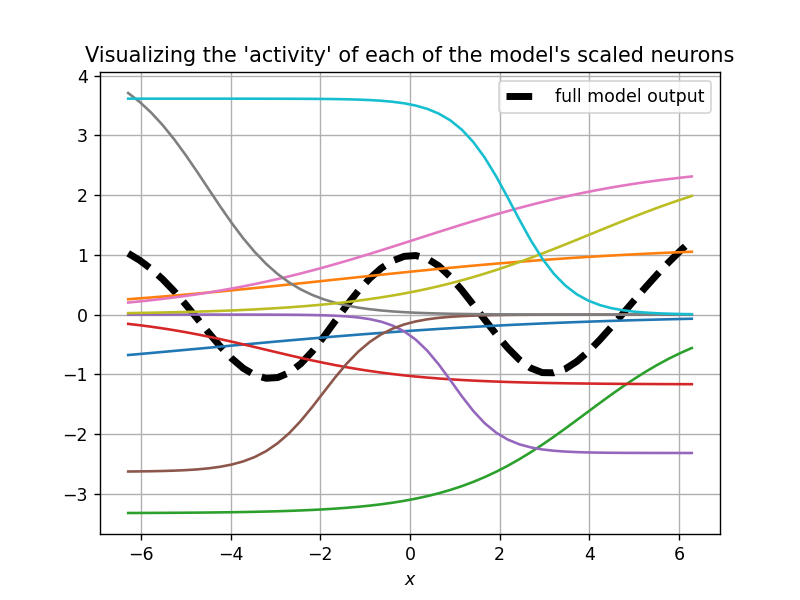

Text(0.5, 0, '$x$')

In [14]:
fig, ax = plt.subplots()
x = np.linspace(-2 * np.pi, 2 * np.pi)

# plots the full model output as a thick dashed black curve
ax.plot(
    x,
    model(x[:, np.newaxis]),
    color="black",
    ls="--",
    lw=4,
    label="full model output",
)



# Add to the plot the scaled activation for each neuron: v σ(x * w + b)
# Plot each of these using the same instance of `Axes`: `ax`.

# Use the same code as in the previous cell, but include v_i in your calculation
# of the neuron's activation

for i in range(model.N):
    w = model.w.ravel()[i]
    b = model.b.ravel()[i]
    v = model.v.ravel()[i]
    
    ax.plot(x,  v * sigmoid(x * w + b))  # plots the activation pattern for that neuron

ax.grid("True")
ax.legend()
ax.set_title("Visualizing the 'activity' of each of the model's scaled neurons")
ax.set_xlabel(r"$x$")

### Things to Try (be sure to preserve any good code you have before trying these things)
- Once you have a good model, try plotting $f(x)$ and $F(x)$ *beyond* the domain that you trained it on. For example, try plotting them on $[-4\pi, 4\pi]$. What do you see? Is this reasonable? Discuss with a neighbor.
  - Dig in a little deeper, plot each of the model's scaled neurons $v_{i}\varphi(\vec{x} \cdot \vec{w}_{i} + b_{i})$ on $[-4\pi, 4\pi]$. You should be able to visually see how the sigmoidal curves will sum outside of $[-2\pi, 2\pi]$
- Once your loss curve (often called the "learning curve") plateaus, try reducing the learning rate by a factor of 5 or 10 and resume training. This will likely lower your loss further.
- Experiment with batch-size. What happens if you use a batch-size of 200 to train your model instead of 25?
- Try decreasing the the parameter-number in your model from $N=10$ down to $N=1$. Thus `w` will have the shape (1, 1) instead of (1, 10), etc. Train this model as best you can, and plot $F(x)$. What shape does this take? Can you explain why?
- Using $N=10$, repeat your training but train on the domain $[2\pi, 6\pi]$. Are you able to get your model to train well? Why should shifting the domain have any affect if $f(x)$ is perfectly periodic. Consider what special properties our original domain, $[-2\pi, 2\pi]$ has. Consider, also, how we initialize our model's parameters. Discuss with your neighbor what you suspect might be the issue here. You can use `noggin` to plot the mean values of `w`, `v`, and `b` as you train. You can also plot the mean values of the gradients that are back-propagating through your model, with some minor modifications to your code. This is very interesting to visualize.
- Fit a different $f(x)$ other than cosine. Do you need more parameters to approximate more complicated functions?
- Try increasing $N$ to $N=100$. You may need to try adjusting your learning rate during training, lowering it as you go. Does increasing $N$ make things better or worse in this instance?

<IPython.core.display.Javascript object>


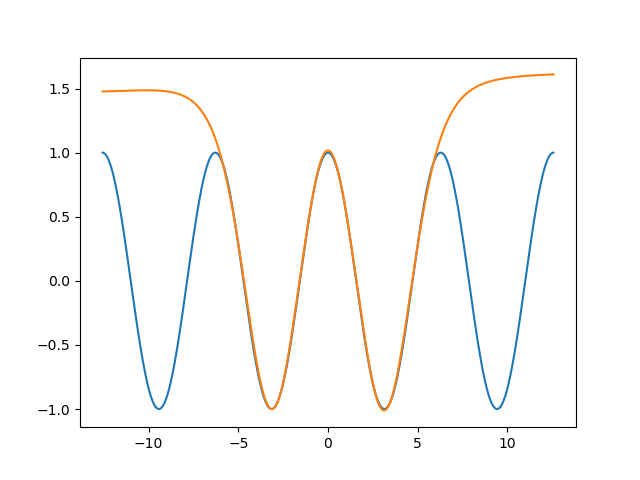

In [36]:
# plotting F(x) outside of its training domain


fig, ax = plt.subplots()
x = np.linspace(-4*np.pi, 4*np.pi, 1000).reshape(-1, 1)
ax.plot(x, true_f(x))
ax.plot(x, model(x).data)


<IPython.core.display.Javascript object>


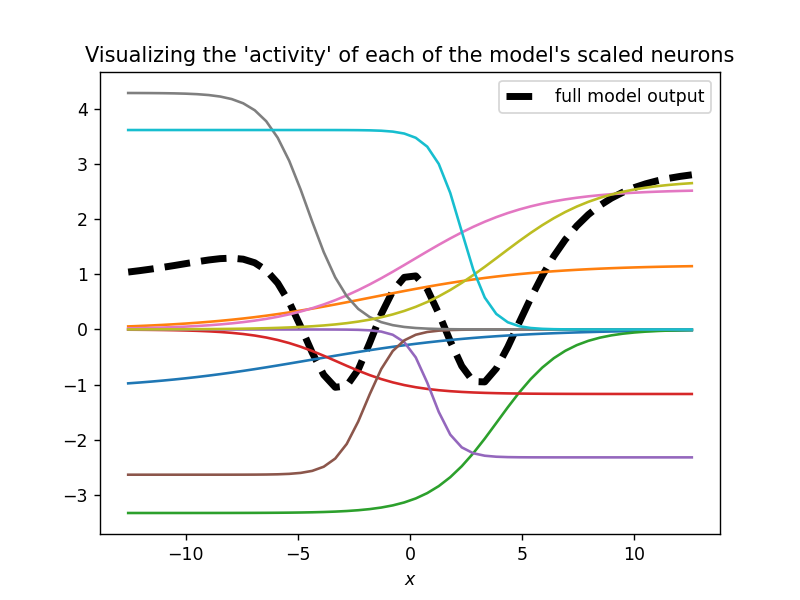

In [16]:
# Plot each of the scaled neurons, v*sigmoid(w*x + b), on [-4 pi, 4 pi]


fig, ax = plt.subplots()
x = np.linspace(-4 * np.pi, 4 * np.pi)

# plots the full model output as a thick dashed black curve
ax.plot(
    x,
    model(x[:, np.newaxis]),
    color="black",
    ls="--",
    lw=4,
    label="full model output",
)

# Using a for-loop, plot the output of each scaled neuron: 
#     v * sigmoid(w*x + b)
for V, W, B in zip(model.v.flatten(), model.w.flatten(), model.b.flatten()):
    ax.plot(x, V * sigmoid(x * W + B))

ax.legend()
ax.set_title("Visualizing the 'activity' of each of the model's scaled neurons")
ax.set_xlabel(r"$x$");


<IPython.core.display.Javascript object>


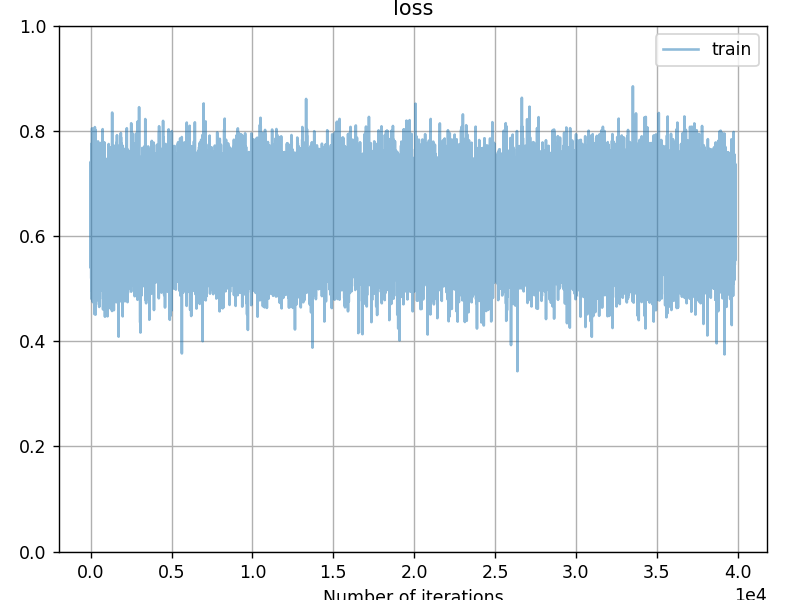

/Users/eriny/opt/anaconda3/lib/python3.9/site-packages/mygrad/nnet/activations/sigmoid.py:16: RuntimeWarning: invalid value encountered in reciprocal
  np.reciprocal(x, out=x)


<IPython.core.display.Javascript object>


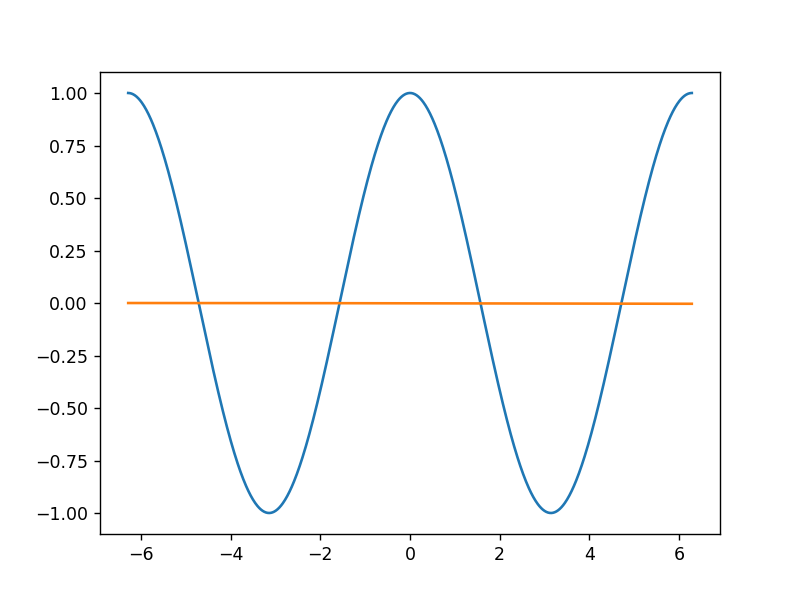

In [17]:
# training the model using N=1

# INTERPRETATION: For N=1, F(x) = v * sigmoid(x*w + b), thus F(x) must
# have the form of a sigmoid function (albeit a shallow one)

# <COGINST>
train_data = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(1000, 1)
model = Model(1)
batch_size = 25


def true_f(x):
    return np.cos(x)
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["loss"])
ax.set_ylim(0, 1)

lr = 0.01

# We will train for 1000 epochs; you can change this if you'd like
for epoch_cnt in range(1000):
    idxs = np.arange(len(train_data))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)

    for batch_cnt in range(0, len(train_data) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]
        batch = train_data[batch_indices]  # random batch of our training data
        prediction = model(batch)
        truth = true_f(batch)
        loss = l1_loss(prediction, truth)
        loss.backward()
        gradient_step(model.parameters, lr)

        plotter.set_train_batch({"loss": loss.item()}, batch_size=batch_size)
fig, ax = plt.subplots()
ax.plot(train_data, true_f(train_data))
ax.plot(train_data, model(train_data).data)
# </COGINST>

<IPython.core.display.Javascript object>


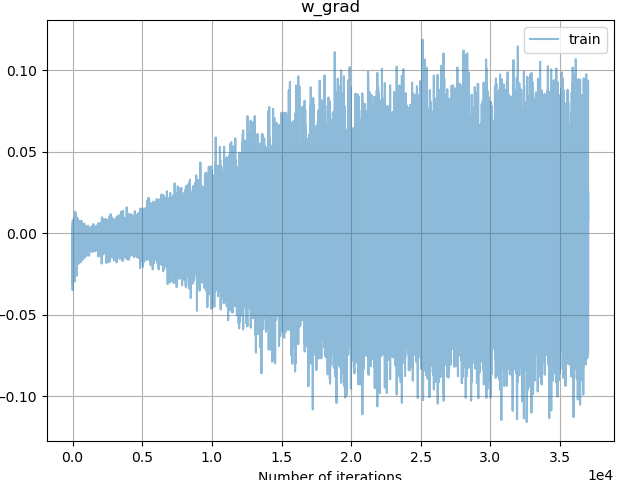

In [37]:
# <COGINST>
from noggin import create_plot
plotter, fig, ax = create_plot(metrics=["w_grad"])
# </COGINST>

<IPython.core.display.Javascript object>


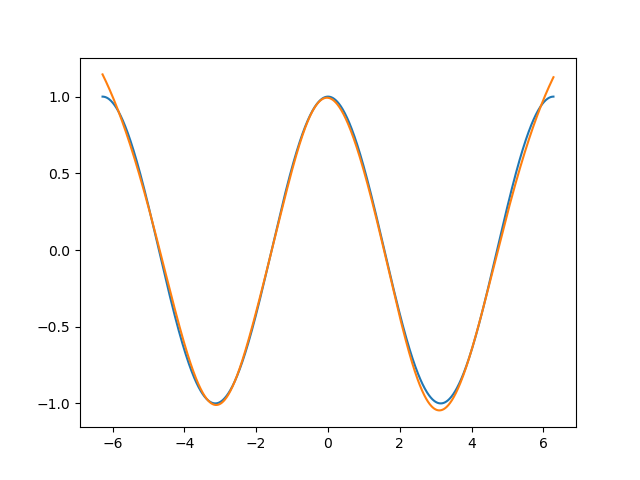

In [38]:
# visualizing w_grad.mean()

# <COGINST>
train_data = np.linspace(-2 * np.pi, 2 * np.pi, 1000).reshape(1000, 1)
model = Model(10)
batch_size = 25


def true_f(x):
    return np.cos(x)


lr = 0.01

# We will train for 1000 epochs; you can change this if you'd like
for epoch_cnt in range(1000):
    idxs = np.arange(len(train_data))  # -> array([0, 1, ..., 9999])
    np.random.shuffle(idxs)

    for batch_cnt in range(0, len(train_data) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]
        batch = train_data[batch_indices]  # random batch of our training data

        prediction = model(batch)

        truth = true_f(batch)
        loss = l1_loss(prediction, truth)
        loss.backward()
        plotter.set_train_batch({"w_grad": model.w.grad.mean()}, batch_size=batch_size)
        gradient_step(model.parameters, lr)

fig, ax = plt.subplots()
ax.plot(train_data, true_f(train_data))
ax.plot(train_data, model(train_data).data)
# </COGINST>